<a href="https://colab.research.google.com/github/Atzelcer/INTELIGENCIA-ARTIFICIAL-II---SIS421/blob/main/RnnAirPassengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Serie temporal con RNN (LSTM)

En este cuadernillo aplicaremos una Red Neuronal Recurrente para predecir valores futuros de una serie temporal mensual. Usaremos el dataset Air Passengers (pasajeros aereos internacionales por mes, 1949–1960), que contiene varios anos y una estacionalidad anual marcada.

## Objetivos
- Comprender el flujo para pronostico de series temporales con RNN (LSTM).
- Explorar y preparar datos (EDA, descomposicion, escalado, ventanas).
- Construir, entrenar y validar un modelo LSTM con early stopping.
- Evaluar con metricas y comparar con baseline ingenuo estacional.
- Generar un pronostico futuro multimes.


In [ ]:
import sys, platform, random, os, math
import numpy as np
import pandas as pd
import tensorflow as tf

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

print('python', sys.version.split()[0])
print('tensorflow', tf.__version__)
print('gpu_available', len(tf.config.list_physical_devices('GPU')) > 0)


python 3.12.11
tensorflow 2.19.0
gpu_available True


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd

filePath = '/content/drive/MyDrive/IA_02/AirPassengers.csv'
df = pd.read_csv(filePath)

print(df.head())
print(df.columns)


     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
Index(['Month', '#Passengers'], dtype='object')


## Preparacion del dataset

Unificamos nombres de columnas, convertimos el campo temporal a tipo datetime y ordenamos la serie por fecha. Para estandarizar, usamos las columnas `Month` y `Passengers`.


In [6]:
import pandas as pd

if '#Passengers' in df.columns:
    df.rename(columns={'#Passengers':'Passengers'}, inplace=True)

if 'Month' in df.columns:
    df['Month'] = pd.to_datetime(df['Month'])

df = df.sort_values('Month').reset_index(drop=True)
df = df[['Month','Passengers']]
df.head()


,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## Exploracion inicial

Graficamos la serie completa, verificamos el rango temporal, la cantidad de filas y la presencia de nulos. Esta vista confirma tendencia y estacionalidad anual tipicas del dataset.


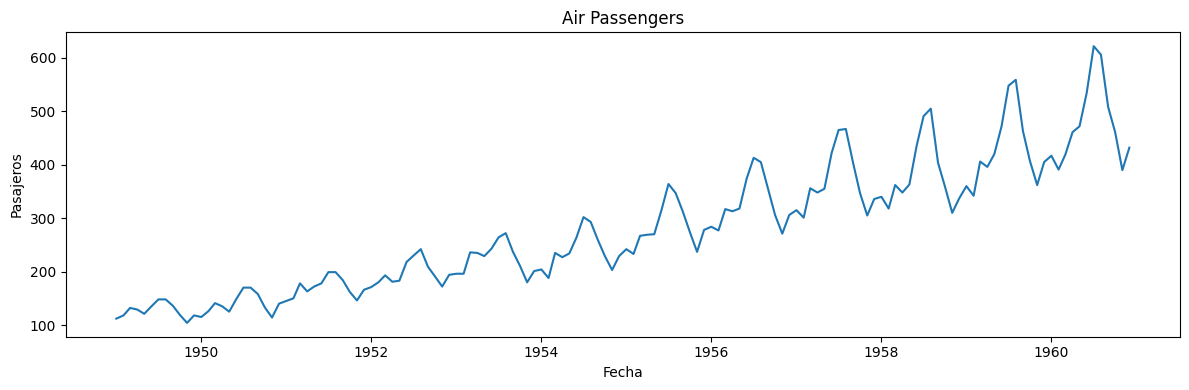

fechas_min 1949-01-01 00:00:00
fechas_max 1960-12-01 00:00:00
num_filas 144
nulos {'Month': 0, 'Passengers': 0}


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df['Month'], df['Passengers'])
plt.title('Air Passengers')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.tight_layout()
plt.show()

print('fechas_min', df['Month'].min())
print('fechas_max', df['Month'].max())
print('num_filas', len(df))
print('nulos', df.isna().sum().to_dict())


## Descomposicion estacional

Aplicamos una descomposicion aditiva con periodo 12 (mensual) para separar tendencia, estacionalidad y residuo. Esto ayuda a justificar el uso de ventanas de 12 meses en la RNN.


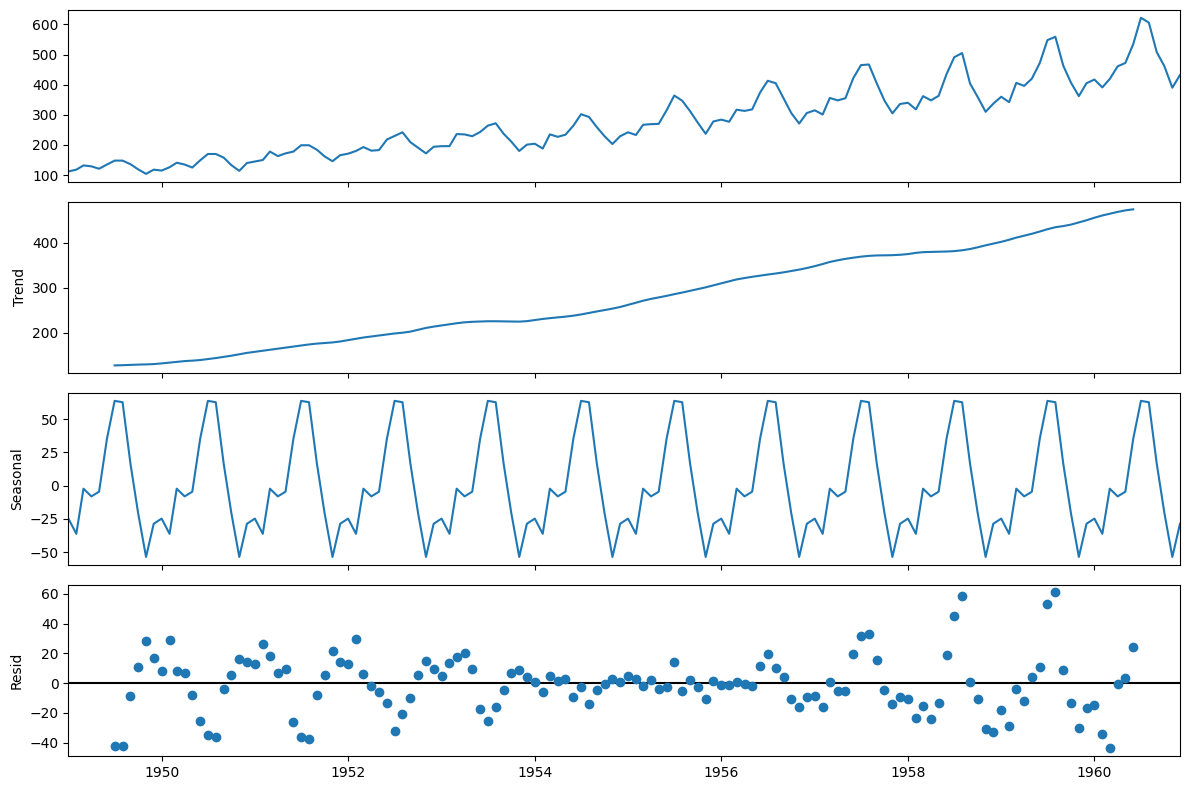

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

serie = pd.Series(df['Passengers'].values, index=pd.PeriodIndex(df['Month'], freq='M').to_timestamp())
res = seasonal_decompose(serie, model='additive', period=12)
fig = res.plot()
fig.set_size_inches(12,8)
plt.tight_layout()
plt.show()


## Particion y escalado

Dividimos la serie en train, val y test respetando el orden temporal (70/15/15). Escalamos con MinMax para estabilizar el entrenamiento de la RNN.


In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math

values = df['Passengers'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

n = len(scaled)
trainSize = int(n * 0.7)
valSize = int(n * 0.15)

train = scaled[:trainSize]
val = scaled[trainSize:trainSize+valSize]
test = scaled[trainSize+valSize:]

print('train_val_test', len(train), len(val), len(test))


train_val_test 100 21 23


## Creacion de ventanas

Transformamos la serie en ejemplos supervisados. Usamos ventanas de tamano 12 para predecir el mes siguiente (horizonte 1).


In [10]:
def makeSequences(a, windowSize, horizon):
    X, y = [], []
    for i in range(len(a) - windowSize - horizon + 1):
        X.append(a[i:i+windowSize, 0])
        y.append(a[i+windowSize:i+windowSize+horizon, 0])
    X = np.array(X).reshape(-1, windowSize, 1)
    y = np.array(y).reshape(-1, horizon)
    return X, y

windowSize = 12
horizon = 1

Xtrain, ytrain = makeSequences(train, windowSize, horizon)
Xval, yval = makeSequences(np.concatenate([train[-windowSize:], val], axis=0), windowSize, horizon)
Xtest, ytest = makeSequences(np.concatenate([train[-windowSize:], val, test], axis=0), windowSize, horizon)

print('shapes', Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)


shapes (88, 12, 1) (88, 1) (21, 12, 1) (21, 1) (44, 12, 1) (44, 1)


## Modelo LSTM y entrenamiento

Arquitectura: LSTM(64) -> Dropout(0.2) -> Dense(1). Optimizador Adam y perdida MAE. Usamos EarlyStopping y ReduceLROnPlateau para mejorar estabilidad y evitar sobreajuste.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(LSTM(64, input_shape=(windowSize,1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mae')

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

hist = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=200, batch_size=16, callbacks=[es, rlr], verbose=0)
print('best_val_loss', min(hist.history['val_loss']))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


best_val_loss 0.10394662618637085


## Curvas de entrenamiento

Visualizamos la perdida en train y val para verificar convergencia y posibles signos de sobreajuste.


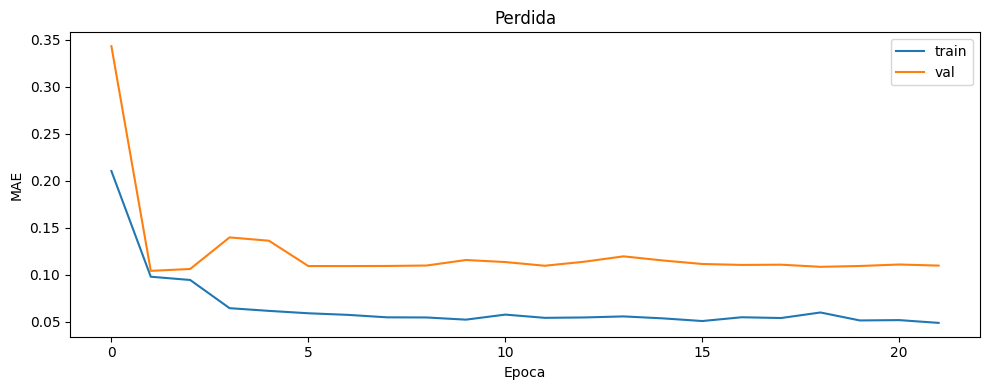

In [12]:
plt.figure(figsize=(10,4))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.title('Perdida')
plt.xlabel('Epoca')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()


## Evaluacion en test y baseline estacional

Calculamos MAE, RMSE y MAPE del modelo y comparamos contra un baseline ingenuo estacional: prediccion de t es el valor observado en t-12.


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def mape(a, b):
    a = np.array(a).astype(float).reshape(-1)
    b = np.array(b).astype(float).reshape(-1)
    return np.mean(np.abs((a - b) / np.maximum(1e-8, a))) * 100.0

predScaled = model.predict(Xtest, verbose=0)
pred = scaler.inverse_transform(predScaled)
true = scaler.inverse_transform(ytest)

mae_model = mean_absolute_error(true, pred)
rmse_model = rmse(true, pred)
mape_model = mape(true, pred)

seriesFull = df['Passengers'].values.reshape(-1,1)
naive = []
for i in range(windowSize, len(seriesFull)):
    naive.append(seriesFull[i-windowSize, 0])
naive = np.array(naive).reshape(-1,1)

naiveTest = naive[-len(true):]

mae_naive = mean_absolute_error(true, naiveTest)
rmse_naive = rmse(true, naiveTest)
mape_naive = mape(true, naiveTest)

print('model_mae', mae_model)
print('model_rmse', rmse_model)
print('model_mape', mape_model)
print('naive_mae', mae_naive)
print('naive_rmse', rmse_naive)
print('naive_mape', mape_naive)


model_mae 60.61871199174361
model_rmse 81.32439871800327
model_mape 13.238552105041974
naive_mae 37.40909090909091
naive_rmse 42.58680973771531
naive_mape 8.646428122164528


## Reales vs predichos en test

Comparamos visualmente los valores reales de test con las predicciones del modelo.


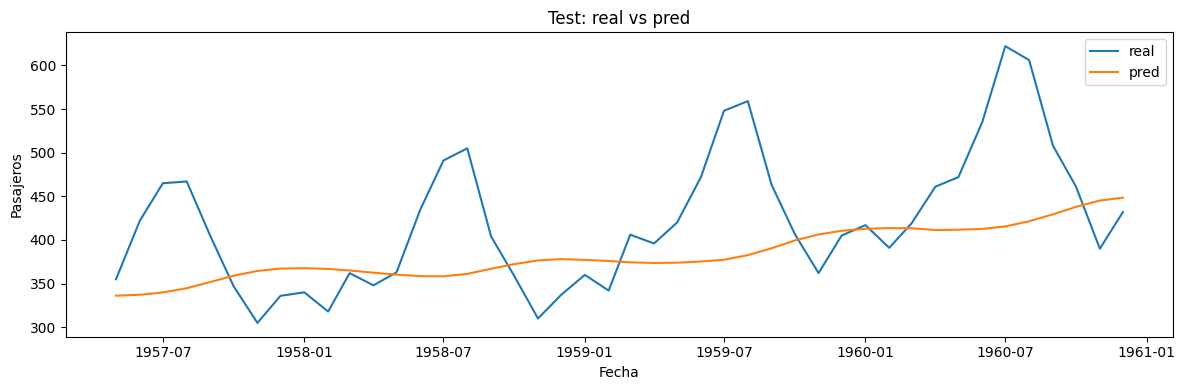

In [14]:
testIndexStart = len(df) - len(true)
plotDates = df['Month'].iloc[testIndexStart:testIndexStart+len(true)].values

plt.figure(figsize=(12,4))
plt.plot(plotDates, true.reshape(-1), label='real')
plt.plot(plotDates, pred.reshape(-1), label='pred')
plt.legend()
plt.title('Test: real vs pred')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.tight_layout()
plt.show()


## Pronostico futuro 24 meses

Generamos un pronostico iterativo a 24 meses partiendo de la ultima ventana disponible.


In [15]:
futureSteps = 24
history = scaled.copy().reshape(-1,1)
futureScaled = []

for i in range(futureSteps):
    x = history[-windowSize:].reshape(1, windowSize, 1)
    yhat = model.predict(x, verbose=0)[0,0]
    history = np.vstack([history, [[yhat]]])
    futureScaled.append(yhat)

future = scaler.inverse_transform(np.array(futureScaled).reshape(-1,1)).reshape(-1)
lastDate = df['Month'].iloc[-1]
futureDates = pd.date_range(lastDate + pd.offsets.MonthBegin(1), periods=futureSteps, freq='MS')

forecastDf = pd.DataFrame({'Month': futureDates, 'Forecast': future})
forecastDf.head()


,Month,Forecast
0,1961-01-01,448.793091
1,1961-02-01,447.906281
2,1961-03-01,447.342163
3,1961-04-01,445.374420
4,1961-05-01,441.738373


## Grafico historico + pronostico

Mostramos la serie historica y el pronostico de 24 meses para visualizar la trayectoria esperada.


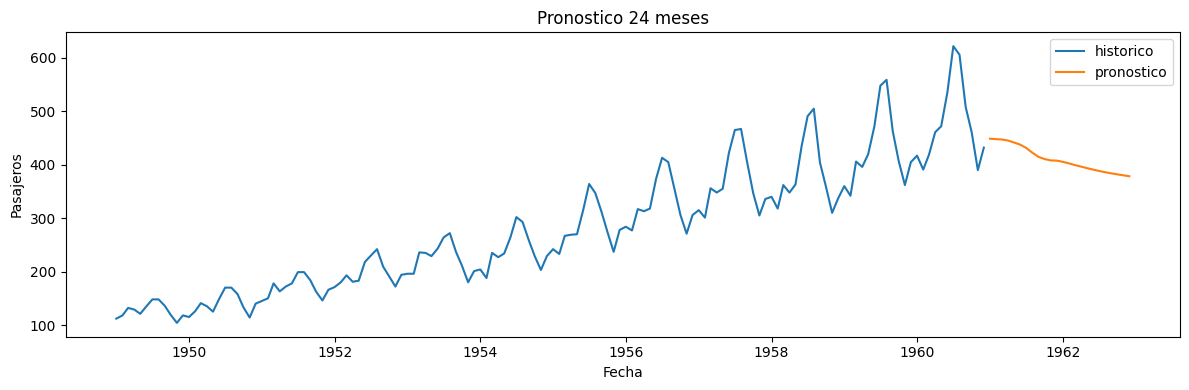

In [16]:
plt.figure(figsize=(12,4))
plt.plot(df['Month'], df['Passengers'], label='historico')
plt.plot(forecastDf['Month'], forecastDf['Forecast'], label='pronostico')
plt.legend()
plt.title('Pronostico 24 meses')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.tight_layout()
plt.show()


## Residuales en test

Inspeccionamos la distribucion de los errores para identificar sesgos sistematicos.


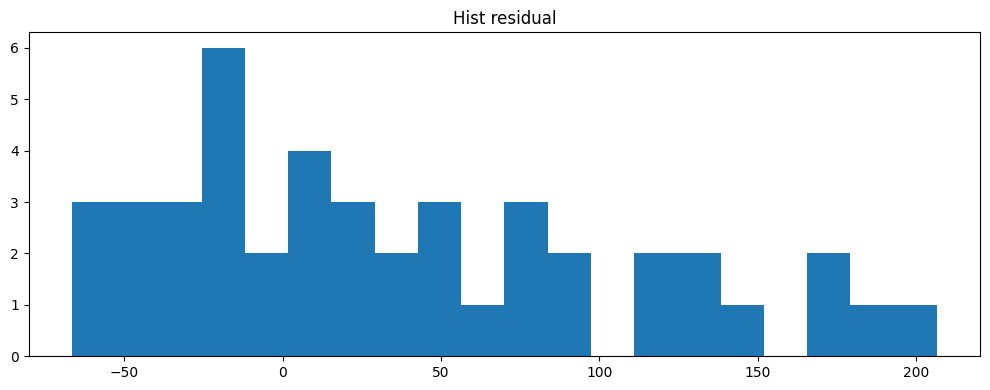

res_mean 37.30558638139205
res_std 72.26306837925766


In [17]:
res = true.reshape(-1) - pred.reshape(-1)
plt.figure(figsize=(10,4))
plt.hist(res, bins=20)
plt.title('Hist residual')
plt.tight_layout()
plt.show()

print('res_mean', np.mean(res))
print('res_std', np.std(res))


## Guardado de artefactos

Guardamos el modelo entrenado y los archivos de resultados (predicciones de test y pronostico futuro).


In [18]:
import os

outDir = '/content/runs_air_rnn'
os.makedirs(outDir, exist_ok=True)

model.save(os.path.join(outDir, 'model_lstm.h5'))
pd.DataFrame({'real': true.reshape(-1), 'pred': pred.reshape(-1)}).to_csv(os.path.join(outDir, 'test_predictions.csv'), index=False)
forecastDf.to_csv(os.path.join(outDir, 'future_forecast.csv'), index=False)

print('saved_to', outDir)


saved_to /content/runs_air_rnn


## Conclusiones

- La serie presenta tendencia y estacionalidad anual, por lo que una ventana de 12 meses es razonable.
- El LSTM captura parte del patron temporal; su desempeno se compara contra un baseline estacional t-12.
- Si la diferencia frente al baseline es reducida, prueba variantes: GRU, mas unidades, ventanas mas grandes, perdida Huber, o incluir regresores externos. Tambien puedes extender el horizonte a multi-step directo (salida densa con k pasos) o usar estrategias recursivas con ensemblado.
